In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Cài đặt cnn
!pip install mtcnn

In [ ]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#mức nhật ký
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [67]:
img = cv.imread("/content/drive/MyDrive/Nhom7_nhanDienKhuonMatSVM/dataset/Khanh_Bang/20210501_132307.jpg")
#opencv BGR chanel format and plt reads images as RGB chanel format

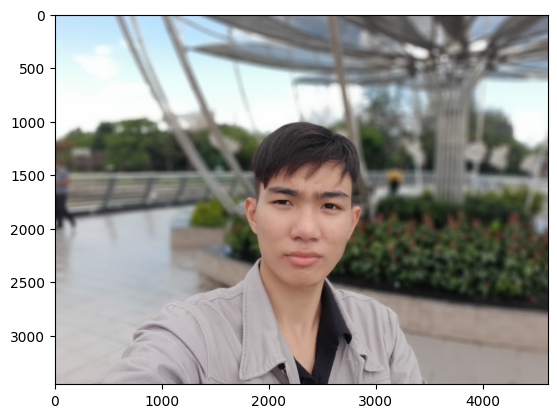

In [68]:
#Chuyển đổi RGB sang BGR
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img) #RGB

In [69]:
from mtcnn.mtcnn import MTCNN
detector = MTCNN()
results = detector.detect_faces(img)

1/1 [==============================] - 0s 172ms/step


In [70]:
results

[{'box': [1824, 1323, 957, 1210],
  'confidence': 0.9999917149543762,
  'keypoints': {'left_eye': (2131, 1761),
   'right_eye': (2569, 1790),
   'nose': (2349, 2045),
   'mouth_left': (2136, 2237),
   'mouth_right': (2512, 2257)}}]

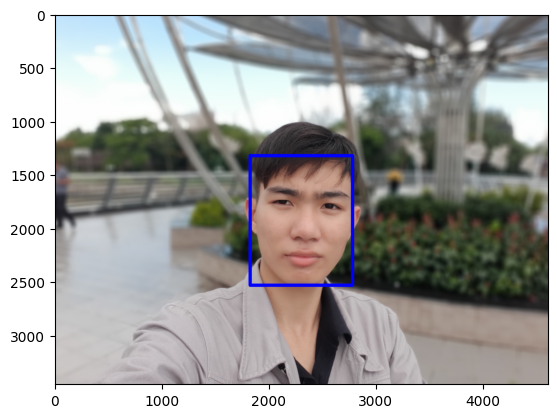

In [71]:
x, y, w, h = results[0]['box']
img = cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 30)
plt.imshow(img)

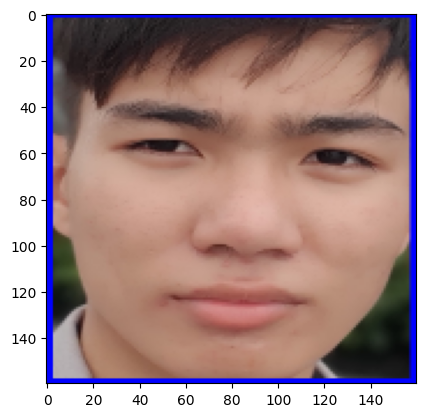

In [72]:
my_face = img[y:y+h, x:x+w]
#Facenet takes as input 160x160
my_face = cv.resize(my_face, (160,160))
plt.imshow(my_face)

In [73]:
my_face

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [ 32,  31, 171],
        [  0,   0, 255],
        [  0,   0, 255]],

       ...,

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [ 12,  12, 151],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]]

Tự động thêm khuôn mặt

In [74]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()


    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr


    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)

        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')

In [75]:
faceloading = FACELOADING("/content/drive/MyDrive/Nhom7_nhanDienKhuonMatSVM/dataset")
X, Y = faceloading.load_classes()

7/7 [==============================] - 0s 62ms/step
Loaded successfully: 58
1/1 [==============================] - 0s 57ms/step
Loaded successfully: 24
1/1 [==============================] - 0s 30ms/step
Loaded successfully: 10
1/1 [==============================] - 0s 28ms/step
Loaded successfully: 10


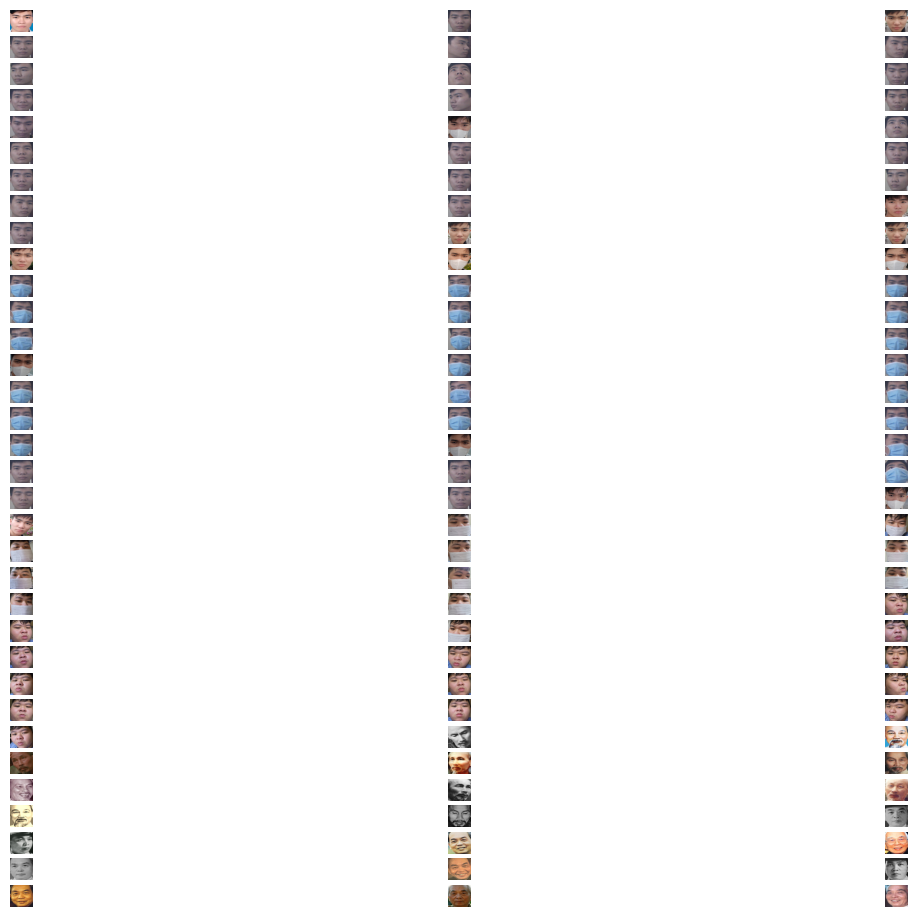

In [76]:
plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 3
    nrows = len(Y)//ncols + 1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')

Face net


In [78]:
#Cài đặt
!pip install keras-facenet

In [79]:
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0)
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

In [80]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 106ms/step


In [96]:
np.savez_compressed('faces_embeddings_done_4classes.npz', EMBEDDED_X, Y)

In [81]:
Y

array(['Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang',
       'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang',
       'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang',
       'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang',
       'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang',
       'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang',
       'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang',
       'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang',
       'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang',
       'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang',
       'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang',
       'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang',
       'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang',
       'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang', 'Khanh_Bang',
       'Khanh_Bang', 'Khanh_Bang', 'Van_Thanh', 'Van_Thanh', 'Van_Thanh',
       'Van_Thanh', 'Van_Thanh', 'Van_Thanh'

SVM Model
So sánh từng mảng với mảng 512 chiều

In [82]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder();
encoder.fit(Y)
Y = encoder.transform(Y)

In [83]:
Y

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)

In [86]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

In [87]:
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

In [88]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_train, ypreds_train)

1.0

In [89]:
accuracy_score(Y_test,ypreds_test)

1.0

In [90]:
t_im = cv.imread("/content/drive/MyDrive/Nhom7_nhanDienKhuonMatSVM/20210215_161144[1].jpg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']

1/1 [==============================] - 0s 67ms/step


In [91]:
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

1/1 [==============================] - 0s 114ms/step


In [92]:
test_im = [test_im]
ypreds = model.predict(test_im)

In [93]:
ypreds

array([2])

In [94]:
encoder.inverse_transform(ypreds)

array(['Khanh_Bang'], dtype='<U10')

In [95]:
import pickle
#save the model
with open('svm_model_160x160.pkl','wb') as f:
    pickle.dump(model,f)